# generate predictions from snapshots

# setup

In [1]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from pathlib import Path

FIGS_DIR = Path(".") / "figs"
FIGS_DIR.mkdir(exist_ok=True)

DATA_DIR = Path(".") / "data"
DATA_DIR.mkdir(exist_ok=True)

SNAPSHOTS_DIR = Path("../../data/") / "snapshots-gen-img"
assert SNAPSHOTS_DIR.exists()

MVTECAD_DIR= Path.home() / "data/mvtec"
assert MVTECAD_DIR.exists()

RECORDS_FPATH = DATA_DIR / "009-generate-predictions-from-snapshots.pkl"


# get snapshots

In [3]:
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
from datetime import timedelta, datetime
import numpy as np
from numpy import ndarray
from typing import Dict, Union, List
from pathlib import Path
import json
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
import copy
from typing import List


# this is to get the strings associated to the classes in the fcdd code
# copied from: fcdd/python/fcdd/datasets/__init__.py
# inside function `str_labels`
# commit: 9f268d8fd2fee33a5c5f38cdfb781da927bdb614
CLASS_LABELS = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'fmnist': [
        't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ],
    'mvtec': [
        'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
        'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
        'wood', 'zipper'
    ],
    # 'imagenet': deepcopy(ADImageNet.ad_classes),
    # this one forwards to: fcdd/python/fcdd/datasets/imagenet.py
    # in: ADImageNet.ad_classes
    # at the same commit as above
    'imagenet': ['acorn', 'airliner', 'ambulance', 'American alligator', 'banjo', 'barn', 'bikini', 'digital clock',
                  'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand piano', 'hotdog', 'hourglass', 'manhole cover',
                  'mosque', 'nail', 'parking meter', 'pillow', 'revolver', 'dial telephone', 'schooner',
                  'snowmobile', 'soccer ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano'],
    'pascalvoc': ['horse'],
}

def get_classes_labels_order(dataset: str) -> List[str]:
    return copy.deepcopy(CLASS_LABELS[dataset])

def get_class_label(class_dirname: str, dataset: str) -> str:
    return CLASS_LABELS[dataset][int(class_dirname.lstrip("normal_"))]

class MissingFileInExperiment(FileNotFoundError):
    pass

class UnfinishedExperiment(Exception):
    pass

def get_snapshots(experiment_dir: Path) -> Dict[str, Union[str, float, ndarray]]:
    """
    :param experiment_dir: path to the experiment directory
    """
    snapshots_dir = experiment_dir / "training_snapshots"
    
    snapshots = []
    for snashotpath in snapshots_dir.glob("snapshotepoch=*.pt"):
        snapshot_name = snashotpath.name
        epoch = int(snashotpath.stem.split("=")[1]) 
        snapshots.append({
            "fpath": snashotpath,
            "snapshot_name": snapshot_name,
            "epoch": epoch,
        })
        
    return snapshots


def get_all(path: Path, dataset: str) -> List[Dict[str, Union[str, float, ndarray]]]:
    
    """
    :param path: a folder that contains dirs like 'fcdd_20211220193242_fmnist_' 
                 a whole experiment on a dataset with all iterations and nominal classes inside, 
                 the structure should look like
                 
                path/
                path/normal_0
                path/normal_1
                ...
                path/normal_9/
                path/normal_9/it_0
                ...
                path/normal_9/it_4/roc.json
    """
    assert path.is_dir()
    assert dataset in CLASS_LABELS
    
    snapshots = []
    
    # 0th level: the runs, e.g. fcdd_20211220193242_fmnist_
    for rundir in path.glob("*"):
        
        print(f"{rundir.name=}")
        if not rundir.is_dir():
            continue

        # first level: classes
        for classdir in rundir.glob("normal_*"):
            
            print(f"{classdir.name=}")
            if not classdir.is_dir():
                continue

            # second level: iterations
            for iterdir in classdir.glob("it_*"):

                print(f"{iterdir.name=}")
                if not iterdir.is_dir():
                    continue

                try: 
                    experiment_snapshots = get_snapshots(iterdir)

                except UnfinishedExperiment as ex:
                    print(f"experiment in {iterdir=} seems to be unfinished, it'll be ignored")
                    continue
                
                for snap in experiment_snapshots:
                    print
                    snapshots.append({
                        **snap,
                        **{
                            "rootdir": path,
                            "rundir": rundir,
                            "classdir": classdir,
                            "iterdir": iterdir,
                            "rundir_name": rundir.name,
                            "classdir_name": classdir.name,
                            "class_idx": int(classdir.name.split("_")[1]),
                            "class_label": get_class_label(classdir.name, dataset),
                            "iterdir_name": iterdir.name,
                            "iter_idx": int(iterdir.name.split("_")[1]),
                        },
                    })
                    
            print(30 * "-")

    return snapshots


# get_all(path=SNAPSHOTS_DIR, dataset="mvtec")

In [4]:
import copy
import pickle

try:
    del records
    
except NameError:
    pass

try:
    print("loading records")
    with RECORDS_FPATH.open("rw") as f:
        records = pickle.load(f)
        
except:
    
    print("couldn't find records, recomputing")
    records = get_all(path=SNAPSHOTS_DIR, dataset="mvtec")

    # print("saving records")
    # with RECORDS_FPATH.open("wb") as f:
    #     pickle.dump(records, f)
        
f"{len(records)=}"

loading records
couldn't find records, recomputing
rundir.name='fcdd_20220202002148_snapshots2_node24_job3040465__mvtec_'
classdir.name='normal_3'
iterdir.name='it_0'
------------------------------


'len(records)=14'

In [5]:
import pandas as pd
index_cols = ["rundir_name", "class_label", "iter_idx", "epoch"]
drop_cols = ["rundir", "classdir", "iterdir", "classdir_name", "iterdir_name"]
df_snapshots = pd.DataFrame.from_records(data=records).set_index(index_cols).drop(columns=drop_cols)
df_snapshots.head(5)

fpath  \
rundir_name                                        class_label iter_idx epoch                                                      
fcdd_20220202002148_snapshots2_node24_job304046... carpet      0        49     ../../data/snapshots-gen-img/fcdd_202202020021...   
                                                                        10     ../../data/snapshots-gen-img/fcdd_202202020021...   
                                                                        13     ../../data/snapshots-gen-img/fcdd_202202020021...   
                                                                        24     ../../data/snapshots-gen-img/fcdd_202202020021...   
                                                                        39     ../../data/snapshots-gen-img/fcdd_202202020021...   

                                                                                        snapshot_name  \
rundir_name                                        class_label iter_idx epoch                           
fcdd_20220202002148_snapshots2_node24_job304046... carpet      0        49     snapshotepoch=00049.pt   
                                                                        10     snapshotepoch=00010.pt   
                                                                        13     snapshotepoch=00013.pt   
                                                                        24     snapshotepoch=00024.pt   
                                                                        39     snapshotepoch=00039.pt   

                                                                                                    rootdir  \
rundir_name                                        class_label iter_idx epoch                                 
fcdd_20220202002148_snapshots2_node24_job304046... carpet      0        49     ../../data/snapshots-gen-img   
                                                                        10     ../../data/snapshots-gen-img   
                                                                        13     ../../data/snapshots-gen-img   
                                                                        24     ../../data/snapshots-gen-img   
                                                                        39     ../../data/snapshots-gen-img   

                                                                               class_idx  
rundir_name                                        class_label iter_idx epoch             
fcdd_20220202002148_snapshots2_node24_job304046... carpet      0        49             3  
                                                                        10             3  
                                                                        13             3  
                                                                        24             3  
                                                                        39             3

display_imgs# select examples

## find dataset images

In [6]:
IMAGES_GLOB = "*.png"

imgs = []

for classdir in MVTECAD_DIR.glob("*"):
    
    if not classdir.is_dir():
        continue    
    
    print(f"{classdir.name=}")
    
    testdir = classdir / "test"
    traindir = classdir / "train"
    
    if not testdir.exists() and not traindir.exists():
        continue
    
    print(f"{testdir.name=}")    
    
    for typedir in testdir.glob("*"):
        
        if not typedir.is_dir():
            continue
        
        print(f"{typedir.name=}")
        
        img_paths = list(typedir.glob(IMAGES_GLOB))
        
        if len(img_paths) == 0:
            print("empty dir")
            continue  
        
        print(f"{len(img_paths)=}")      
        
        for imgpath in img_paths:
            imgs.append({
                "imgpath": imgpath,
                "class": classdir.name,
                "type": typedir.name,
                "set": "test",
                "imgidx": int(imgpath.stem),
            })
            
    print(f"{traindir.name=}")
    
    img_paths = list((traindir / "good").glob(IMAGES_GLOB))
    
    if len(img_paths) == 0:
        print("empty dir")

    else:
        for imgpath in img_paths:
            imgs.append({
                "imgpath": imgpath,
                "class": classdir.name,
                "type": "good",
                "set": "train",
                "imgidx": int(imgpath.stem),
            })    
    
    print(30 * "-")

print(f"{len(imgs)=}")

classdir.name='tile'
testdir.name='test'
typedir.name='gray_stroke'
len(img_paths)=16
typedir.name='rough'
len(img_paths)=15
typedir.name='crack'
len(img_paths)=17
typedir.name='good'
len(img_paths)=33
typedir.name='glue_strip'
len(img_paths)=18
typedir.name='oil'
len(img_paths)=18
traindir.name='train'
------------------------------
classdir.name='metal_nut'
testdir.name='test'
typedir.name='scratch'
len(img_paths)=23
typedir.name='bent'
len(img_paths)=25
typedir.name='color'
len(img_paths)=22
typedir.name='good'
len(img_paths)=22
typedir.name='flip'
len(img_paths)=23
traindir.name='train'
------------------------------
classdir.name='pill'
testdir.name='test'
typedir.name='pill_type'
len(img_paths)=9
typedir.name='scratch'
len(img_paths)=24
typedir.name='combined'
len(img_paths)=17
typedir.name='color'
len(img_paths)=25
typedir.name='crack'
len(img_paths)=26
typedir.name='good'
len(img_paths)=26
typedir.name='faulty_imprint'
len(img_paths)=19
typedir.name='contamination'
len(img_path

In [7]:
import pandas as pd
imgs = pd.DataFrame.from_records(data=imgs).set_index(["class", "set", "type", "imgidx"])
imgs

imgpath
class  set   type        imgidx                                                   
tile   test  gray_stroke 9       /home/jcasagrandebertoldo/data/mvtec/tile/test...
                         10      /home/jcasagrandebertoldo/data/mvtec/tile/test...
                         14      /home/jcasagrandebertoldo/data/mvtec/tile/test...
                         15      /home/jcasagrandebertoldo/data/mvtec/tile/test...
                         0       /home/jcasagrandebertoldo/data/mvtec/tile/test...
...                                                                            ...
carpet train good        51      /home/jcasagrandebertoldo/data/mvtec/carpet/tr...
                         187     /home/jcasagrandebertoldo/data/mvtec/carpet/tr...
                         183     /home/jcasagrandebertoldo/data/mvtec/carpet/tr...
                         206     /home/jcasagrandebertoldo/data/mvtec/carpet/tr...
                         94      /home/jcasagrandebertoldo/data/mvtec/carpet/tr...

[5354 rows x 1 columns]

## select

In [8]:
%matplotlib inline

In [9]:
from pandas import DataFrame

selected_class = "carpet"

class_imgs = imgs.loc[selected_class]

def get_indices_summary(df_: DataFrame) -> DataFrame:
    return df_.reset_index()[df_.index.names].groupby(df_.index.names[0:2]).agg(["min", "max"])

get_indices_summary(class_imgs)

imgidx     
                             min  max
set   type                           
test  color                    0   18
      cut                      0   16
      good                     0   27
      hole                     0   16
      metal_contamination      0   16
      thread                   0   18
train good                     0  279

In [10]:
import matplotlib.pyplot as plt

def display_imgs_plt(df_: DataFrame, figsize=4):
    fig, axs = plt.subplots(
        ncols=(ncols:=3), 
        nrows=(nrows:=display_imgs.size // ncols + 1), 
        figsize=(ncols * (sz:=4), nrows * sz),
    )
    ims = []
    
    for idx, ax in enumerate(axs.ravel()):
        
        try:
            row = display_imgs.iloc[idx]
            
        except IndexError:
            continue
        
        else:
            im = ax.imshow(plt.imread(row.imgpath))
            ims.append(im)
            set_, type_, imidx = row.name
            ax.set_title(f"{set_=} {type_=} {imidx=}", fontsize='small')
            
        finally:
            ax.axis(False)

    return fig, axs, ims

In [11]:
class_imgs.index.get_level_values(1).unique()

Index(['cut', 'color', 'thread', 'good', 'metal_contamination', 'hole'], dtype='object', name='type')

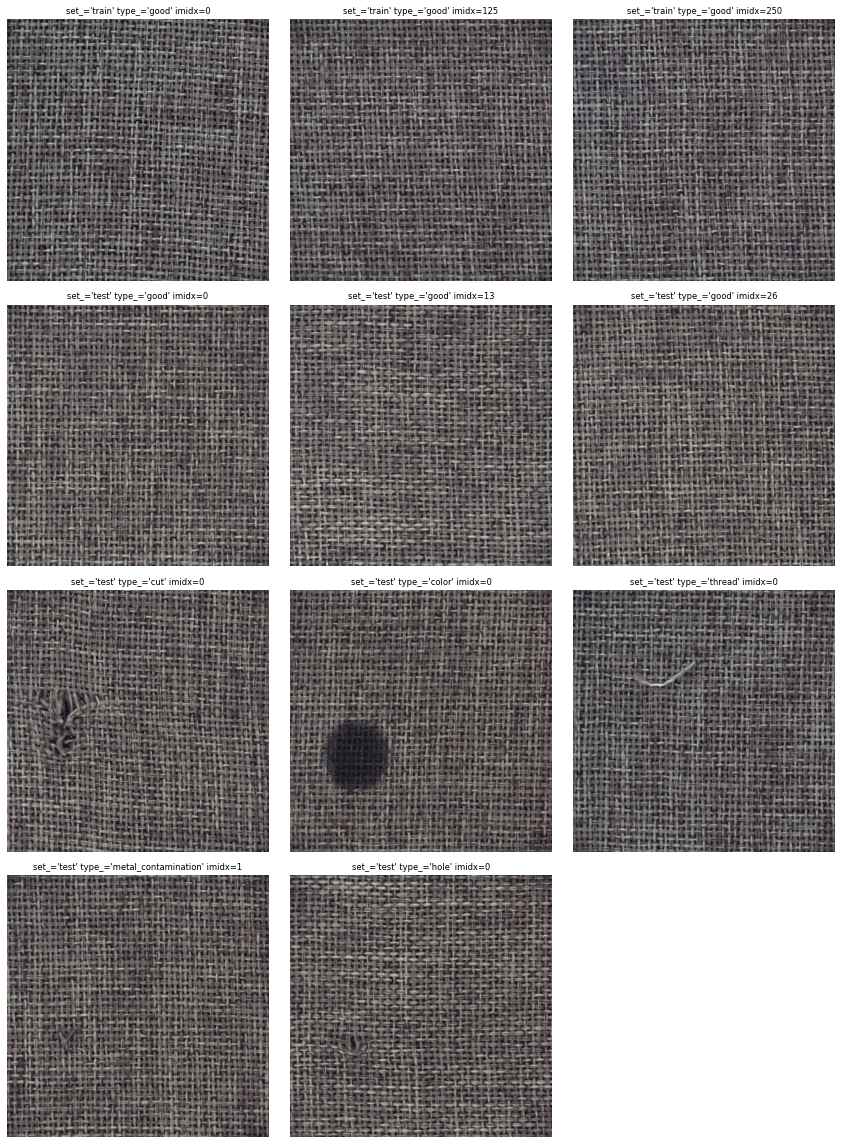

In [12]:
display_imgs = class_imgs.loc[[
    ("train", "good", 0),
    ("train", "good", 125),
    ("train", "good", 250),
    ("test", "good", 0),
    ("test", "good", 13),
    ("test", "good", 26),
    ("test", "cut", 0),
    ("test", "color", 0),
    ("test", "thread", 0),
    ("test", "metal_contamination", 1),
    ("test", "hole", 0),
]]

fig, axs, ims = display_imgs_plt(display_imgs)
fig.set_tight_layout(True)
plt.show()

In [13]:
from pandas import DataFrame
import time
from pathlib import Path
from typing import List


def create_tmpdir(img_fpaths: List[Path], tmp_dpath: Path):

    tmp_img_dir = tmp_dpath / tmp_dpath.name
    tmp_img_dir.mkdir(parents=True)

    for img_fpath in img_fpaths:
        # create a file name with the parents names
        symlink_name = f"{img_fpath.parent.parent.parent.name}-{img_fpath.parent.parent.name}-{img_fpath.parent.name}-{img_fpath.name}"
        symlink_fpath = tmp_img_dir / symlink_name
        symlink_fpath.symlink_to(img_fpath)

tmp_dpath = DATA_DIR / f"tmp_{int(time.time())}"        

create_tmpdir(
    img_fpaths = display_imgs["imgpath"],
    tmp_dpath = tmp_dpath,
)

# generate explanations

I based stuff on the script `fcdd/python/fcdd/runners/run_prediction_with_snapshot.py`.


In [14]:
import torch
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

In [15]:
%load_ext autoreload

In [16]:
%autoreload 2
from fcdd.training.fcdd import FCDDTrainer
from fcdd.models.fcdd_cnn_224 import FCDD_CNN224_VGG_F
from fcdd.datasets.image_folder import ImageFolder
from fcdd.datasets.preprocessing import local_contrast_normalization
from fcdd.util.logging import Logger

In [17]:
min_max_l1 = [
    [(-1.3336724042892456, -1.3107913732528687, -1.2445921897888184),
     (1.3779616355895996, 1.3779616355895996, 1.3779616355895996)],
    [(-2.2404820919036865, -2.3387579917907715, -2.2896201610565186),
     (4.573435306549072, 4.573435306549072, 4.573435306549072)],
    [(-3.184587001800537, -3.164201259613037, -3.1392977237701416),
     (1.6995097398757935, 1.6011602878570557, 1.5209171772003174)],
    [(-3.0334954261779785, -2.958242416381836, -2.7701096534729004),
     (6.503103256225586, 5.875098705291748, 5.814228057861328)],
    [(-3.100773334503174, -3.100773334503174, -3.100773334503174),
     (4.27892541885376, 4.27892541885376, 4.27892541885376)],
    [(-3.6565306186676025, -3.507692813873291, -2.7635035514831543),
     (18.966819763183594, 21.64590072631836, 26.408710479736328)],
    [(-1.5192601680755615, -2.2068002223968506, -2.3948357105255127),
     (11.564697265625, 10.976534843444824, 10.378695487976074)],
    [(-1.3207964897155762, -1.2889339923858643, -1.148416519165039),
     (6.854909896850586, 6.854909896850586, 6.854909896850586)],
    [(-0.9883341193199158, -0.9822461605072021, -0.9288841485977173),
     (2.290637969970703, 2.4007883071899414, 2.3044068813323975)],
    [(-7.236185073852539, -7.236185073852539, -7.236185073852539),
     (3.3777384757995605, 3.3777384757995605, 3.3777384757995605)],
    [(-3.2036616802215576, -3.221003532409668, -3.305514335632324),
     (7.022546768188477, 6.115569114685059, 6.310940742492676)],
    [(-0.8915618658065796, -0.8669204115867615, -0.8002046346664429),
     (4.4255571365356445, 4.642300128936768, 4.305730819702148)],
    [(-1.9086798429489136, -2.0004451274871826, -1.929288387298584),
     (5.463134765625, 5.463134765625, 5.463134765625)],
    [(-2.9547364711761475, -3.17536997795105, -3.143850803375244),
     (5.305514812469482, 4.535006523132324, 3.3618252277374268)],
    [(-1.2906527519226074, -1.2906527519226074, -1.2906527519226074),
     (2.515115737915039, 2.515115737915039, 2.515115737915039)]
]

In [18]:
from fcdd.datasets import load_dataset
from fcdd.runners.run_mvtec import MvtecConfig
from argparse import ArgumentParser

In [19]:
parser = ArgumentParser()
parser = MvtecConfig()(parser)
dftargs = parser.parse_args("")

In [23]:
# todo change me
OUTPUTS_DIR = DATA_DIR.absolute()

In [24]:
# [optional] to generate heatmaps, define a logger (with the path where the heatmaps should be saved to) and a quantile
exp_start_time = int(time.time())
logger = Logger(str(OUTPUTS_DIR), exp_start_time=exp_start_time)
quantile = 0.97

In [29]:
def gen_heatmaps_for_training(list_epochs, list_snaphots_paths, normal_class):
    
    assert len(list_epochs) == len(list_snaphots_paths)
    assert len(list_epochs) > 0
    
    net = FCDD_CNN224_VGG_F((3, 224, 224), bias=True)
    
    # Use the same test transform as was used for training the snapshot (e.g., for mvtec, per default, the following)
    transform = transforms.Compose([
        transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: local_contrast_normalization(x, scale='l1')),
        transforms.Normalize(
            min_max_l1[normal_class][0],
            [ma - mi for ma, mi in zip(min_max_l1[normal_class][1], min_max_l1[normal_class][0])]
        )
    ])
    
    all_all_inputs = []
    all_all_labels = []
    all_all_anomaly_scores_pixelwise = [] 
    all_all_anomaly_scores_imgwise = [] 
    
    for epoch, snapshot_fpath in zip(list_epochs, list_snaphots_paths):

        trainer = FCDDTrainer(net, None, None, (None, None), logger, 'fcdd', 8, quantile, 224)
        trainer.load(str(snapshot_fpath), cpu=True)
        trainer.net.eval();

        data_set = ImageFolder(tmp_dpath, transform)
        loader = DataLoader(data_set, batch_size=8, num_workers=0)

        all_anomaly_scores, all_inputs, all_labels = [], [], []
        for inputs, labels in loader:
            # inputs = inputs.cuda()
            with torch.no_grad():
                outputs = trainer.net(inputs)
                anomaly_scores = trainer.anomaly_score(trainer.loss(outputs, inputs, labels, reduce='none'))
                anomaly_scores = trainer.net.receptive_upsample(anomaly_scores, reception=True, std=8, cpu=False)
                all_anomaly_scores.append(anomaly_scores.cpu())
                all_inputs.append(inputs.cpu())
                all_labels.append(labels)

        all_inputs = torch.cat(all_inputs)
        all_labels = torch.cat(all_labels)
        # all_anomaly_scores will be a tensor containing pixel-wise anomaly scores for all images
        anomaly_scores_pixelwise = torch.cat(all_anomaly_scores)
        anomaly_scores_imgwise = trainer.reduce_ascore(anomaly_scores_pixelwise)
        
        all_all_inputs.append(all_inputs)
        all_all_labels.append(all_labels)
        all_all_anomaly_scores_pixelwise.append(anomaly_scores_pixelwise)
        all_all_anomaly_scores_imgwise.append(anomaly_scores_imgwise)
    
    all_all_inputs = torch.cat([torch.unsqueeze(t, 0) for t in all_all_inputs], dim=0)
    all_all_labels = torch.cat([torch.unsqueeze(t, 0) for t in all_all_labels], dim=0)
    all_all_anomaly_scores_pixelwise = torch.cat([torch.unsqueeze(t, 0) for t in all_all_anomaly_scores_pixelwise], dim=0)
    all_all_anomaly_scores_imgwise = torch.cat([torch.unsqueeze(t, 0) for t in all_all_anomaly_scores_imgwise], dim=0)
    
    return all_all_inputs, all_all_labels, all_all_anomaly_scores_pixelwise, all_all_anomaly_scores_imgwise

In [32]:
index0 = df_snapshots.index.get_level_values(0).unique()[0]
df_ = df_snapshots.loc[index0]

normal_class_label = df_.index.get_level_values(0).unique()[0]
df_ = df_.loc[normal_class_label]

iter_idx = df_.index.get_level_values(0).unique()[0]
df_ = df_.loc[iter_idx]

df_ = df_.sort_index(0)

list_epochs = df_.index.get_level_values(0).unique()
list_snaphots_paths = list(df_["fpath"])

inputs, labels, as_pixelwise, as_imgwise = gen_heatmaps_for_training(
    list_epochs=list_epochs, 
    list_snaphots_paths=list_snaphots_paths,
    normal_class=get_classes_labels_order("mvtec").index(normal_class_label)
)

del labels

Loaded net_state, opt_state, sched_state with starting epoch 0 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 1 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 2 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 4 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 7 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 10 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 13 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 16 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 19 for fcdd.training.fcdd.FCDDTrainer
Loaded net_state, opt_state, sched_state with starting epoch 24 for fcdd.training.fcdd.FCDDTrainer
Loaded net_stat

In [33]:
inputs.shape
as_pixelwise.shape
as_imgwise.shape

torch.Size([14, 11, 3, 224, 224])

torch.Size([14, 11, 1, 224, 224])

torch.Size([14, 11])

# plot

In [34]:
import matplotlib.pyplot as plt
import numpy as np

In [59]:
snapshots_as_mins = np.min(as_pixelwise.numpy(), axis=(1, 2, 3, 4))
snapshots_as_maxs = np.max(as_pixelwise.numpy(), axis=(1, 2, 3, 4))

In [115]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [120]:
%%time
import matplotlib as mpl

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [126]:
%%time

selected_heatmaps = as_pixelwise[:, :, :].numpy()  # [snap, img, channel]
selected_inputs = inputs[:, :, :].numpy() 

nb_img = selected_heatmaps.shape[1]
nb_snapshots = selected_heatmaps.shape[0]

nb_row, nb_col = nb_img * 3, nb_snapshots

fig, axs = plt.subplots(nb_row, nb_col, figsize=(nb_snapshots*5,2*nb_img*5), dpi=100, gridspec_kw={'height_ratios': nb_img * [1, 1, .15]})

for idx_img in range(nb_img):
    axs_img, axs_map, axs_scale = axs[3 * idx_img:3 * (idx_img + 1)]
    for ax_img, ax_map, ax_scale, heat_map, img, as_min, as_max, epoch in zip(
        axs_img, 
        axs_map, 
        axs_scale,
        selected_heatmaps[:, idx_img, :], 
        selected_inputs[:, idx_img, :], 
        snapshots_as_mins, 
        snapshots_as_maxs,
        list_epochs,
    ):
        img = np.mean(img, axis=0)
        ax_img.imshow(img, cmap='gray', alpha=1, vmin=0, vmax=1)
        im_heatmap = ax_map.imshow(heat_map.squeeze(), cmap='jet', alpha=1, vmin=as_min, vmax=as_max)
        
        # fig.colorbar(im_heatmap, cax=ax_scale, orientation='horizontal')
        
        ax_img.axis(False)
        ax_map.axes.xaxis.set_ticks([])
        ax_map.axes.yaxis.set_ticks([])
        ax_map.set_xlabel(f"{epoch=}")
        
        cmap = mpl.cm.jet
        norm = mpl.colors.Normalize(vmin=as_min, vmax=as_max)
        cb1 = mpl.colorbar.ColorbarBase(ax_scale, cmap=cmap, norm=norm, orientation='horizontal')
        
fig.set_tight_layout(True)
fig.savefig(FIGS_DIR / "heatmaps.png")
plt.close()

CPU times: user 23.9 s, sys: 235 ms, total: 24.1 s
Wall time: 24 s
